<a href="https://colab.research.google.com/github/sampintu8658/10/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**For Extract text**


In [1]:
!pip install -U -q google-generativeai
!apt-get install -y poppler-utils
!pip install -q -U google-generativeai pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 0s (1,550 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
import json
import pathlib
import textwrap

import google.generativeai as genai


from IPython.display import display
from IPython.display import Markdown

from google.api_core import retry

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [3]:
try:
    # Used to securely store your API key
    from google.colab import userdata

    # Or use `os.getenv('API_KEY')` to fetch an environment variable.
    GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
except ImportError:
    pass

In [4]:
import google.generativeai as genai
from google.colab import userdata
from pathlib import Path
from pdf2image import convert_from_path

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

MODEL_CONFIG = {
    "temperature": 0.2,
    "top_p": 1,
    "top_k": 32,
    "max_output_tokens": 4096,
}

# Safety Settings of Model
safety_settings = [
    {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"},
    {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_MEDIUM_AND_ABOVE"}
]

model = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=MODEL_CONFIG,
    safety_settings=safety_settings
)

def image_format(image_path):
    img = Path(image_path)

    if not img.exists():
        raise FileNotFoundError(f"Could not find image: {img}")

    image_parts = [
        {
            "mime_type": "image/png",  # Change to "image/jpeg" if needed
            "data": img.read_bytes()
        }
    ]
    return image_parts

def pdf_to_image(pdf_path, output_format='png'):

    images = convert_from_path(pdf_path)


    image_paths = []
    for i, image in enumerate(images):
        image_path = f"/content/page_{i + 1}.{output_format}"
        image.save(image_path, output_format.upper())
        image_paths.append(image_path)
    return image_paths

def gemini_output(image_path, system_prompt, user_prompt):
    image_info = image_format(image_path)
    input_prompt = [system_prompt, image_info[0], user_prompt]
    response = model.generate_content(input_prompt)
    return response.text


pdf_path = input("Enter your pdf file :")
output_image_paths = pdf_to_image(pdf_path, output_format='png')

image_path = output_image_paths[0]

system_prompt = """
    You are a specialist in comprehending receipts.
    Input images in the form of receipts will be provided to you,
    and your task is to respond to questions based on the content of the input image.
"""

user_prompt = "Convert Invoice data into json format with appropriate json tags as required for the data in image with iteams and their price also"

output = gemini_output(image_path, system_prompt, user_prompt)


Enter your pdf file :/content/drive/MyDrive/Resumesameer/INV-102_Kasturi Kalwar.pdf


In [5]:
to_markdown(output)

> ```json
> {"Invoice Number": "INV-102", "Invoice Date": "24 Jan 2024", "Due Date": "24 Jan 2024", "Customer Details": "Kasturi Kalwar", "Place of Supply": "23-MADHYA PRADESH", "Items": [{"Item": "Acne-UV Gel - spf 50 (50 gm)", "Rate": "620.34", "Qty": "1 PAC", "Taxable Value": "620.34", "Tax Amount": "111.66 (18%)", "Amount": "732.00"}, {"Item": "Cetaphil gentle cleansing lotion - 250 ML", "Rate": "443.01", "Qty": "2", "Taxable Value": "886.02", "Tax Amount": "159.48 (18%)", "Amount": "1,045.50"}, {"Item": "Depewhite Advanced Cream - 15 ml", "Rate": "479.03", "Qty": "1 TUB", "Taxable Value": "479.03", "Tax Amount": "86.22 (18%)", "Amount": "565.25"}, {"Item": "Neurobion Forte - 30 tablets", "Rate": "31.27", "Qty": "3 STRP", "Taxable Value": "93.81", "Tax Amount": "16.89 (18%)", "Amount": "110.70"}, {"Item": "Benzac AC 2.5%", "Rate": "82.34", "Qty": "1 PAC", "Taxable Value": "82.34", "Tax Amount": "9.88 (12%)", "Amount": "92.22"}], "Total Items": "5", "Total amount (in words)": "INR Two Thousand, Five Hundred And Forty-Six Rupees Only.", "Total Taxable Amount": "2,161.54", "CGST 6.0%": "4.94", "SGST 6.0%": "4.94", "CGST 9.0%": "187.13", "SGST 9.0%": "187.13", "Round Off": "0.33", "Total": "2,546.00", "Total Discount": "495.82", "Bank": "Kotak Mahindra Bank", "Account #": "1146860541", "IFSC Code": "kkbk0000725", "Branch": "PUNE - CHINCHWAD", "UnCue Dermacare Pvt Ltd": "UnCue Dermacare Pvt Ltd"}
> ```

In [6]:
# model = genai.GenerativeModel(
#     model_name='models/gemini-1.5-pro-latest')



In [7]:
response = model.generate_content(
    textwrap.dedent("""
    {
        "Invoice #/Invoice Number": "",
        "Invoice Date": "",
        "Due Date": "",
        "Mobile / ph": "",
        "Email / email": "",
        "Customer Details": "",
        "Shipping Address": "",
        "Place of Supply": "",
        "Total Items": "",
        "items": [
            {
                "Item": "",
                "Rate/Item": "",
                "Qty": "",
                "Taxable Value": "",
                "Tax Amount": "",
                "Amount": ""
            }
        ],
        "Total amount (in words)": "",
        "Total Discount": "",
        "Total": "",
        "Taxable Amount": "",
        "CGST 6.0%": "",
        "SGST 6.0%": "",
        "CGST 9.0%": "",
        "SGST 9.0%": "",
        "IGST 12.0%": "",
        "IGST 18.0%": "",
        "Round Off": "",
        "Bank": "",
        "Account #": "",
        "IFSC Code": "",
        "Branch": "",
        "Address": "",
        "Amount Paid": ""
    }
    """) + output,
    generation_config={'response_mime_type': 'application/json'}
)


In [8]:
from transformers import pipeline
import json
import textwrap


model = pipeline('text-generation', model='gpt2')

def generate_invoice_content(invoice_json, output):

    invoice_data_str = json.dumps(invoice_json, indent=4)


    prompt = textwrap.dedent(f"""
        Here is the invoice data:
        {invoice_data_str}

        Please generate a formatted invoice content based on the above details, including items and their amounts.
    """)


    response = model(prompt, max_length=900, num_return_sequences=1)


    generated_text = response[0]['generated_text']
    return generated_text

def main():

    invoice_json_input = {
        "Invoice Number": "",
        "Invoice Date": "",
        "Due Date": "",
        "Customer Name" : "",
        "Mobile" : "",
        "Email" : "",
        "Total Items": "",
        "Place of Supply" : "",
        "Total amount (in words)" : "",
        "Total": "",
        "items": [
            {"Item": "", "Rate/Item": "", "Qty": "", "Taxable Value": "", "Tax Amount": "", "Amount": ""}
            # Add more items as needed
        ],
        "Taxable Amount": "",
        "CGST 6.0%": "",
        "SGST 6.0%": "",
        "CGST 9.0%": "",
        "SGST 9.0%": "",
        "IGST 12.0%": "",
        "IGST 18.0%": "",
        "Round Off": "",
        "Bank": "",
        "Account #": "",
        "IFSC Code": "",
        "Branch": "",
        "Company Name" : "",
        "Address" : "",
        "Amount Paid": ""

    }


    output = "Your additional information goes here."


    response = generate_invoice_content(invoice_json_input, output)

    print(response)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



        Here is the invoice data:
        {
    "Invoice Number": "",
    "Invoice Date": "",
    "Due Date": "",
    "Customer Name": "",
    "Mobile": "",
    "Email": "",
    "Total Items": "",
    "Place of Supply": "",
    "Total amount (in words)": "",
    "Total": "",
    "items": [
        {
            "Item": "",
            "Rate/Item": "",
            "Qty": "",
            "Taxable Value": "",
            "Tax Amount": "",
            "Amount": ""
        }
    ],
    "Taxable Amount": "",
    "CGST 6.0%": "",
    "SGST 6.0%": "",
    "CGST 9.0%": "",
    "SGST 9.0%": "",
    "IGST 12.0%": "",
    "IGST 18.0%": "",
    "Round Off": "",
    "Bank": "",
    "Account #": "",
    "IFSC Code": "",
    "Branch": "",
    "Company Name": "",
    "Address": "",
    "Amount Paid": ""
}

        Please generate a formatted invoice content based on the above details, including items and their amounts.

{

"Price": "11.99", "Quantity": "100", "Price": "11.99"

"Item Quantity": "1", "I

In [9]:
response.text

'{"Invoice Number": "INV-102", "Invoice Date": "24 Jan 2024", "Due Date": "24 Jan 2024", "Customer Details": "Kasturi Kalwar", "Place of Supply": "23-MADHYA PRADESH", "Items": [{"Item": "Acne-UV Gel - spf 50 (50 gm)", "Rate": "620.34", "Qty": "1 PAC", "Taxable Value": "620.34", "Tax Amount": "111.66 (18%)", "Amount": "732.00"}, {"Item": "Cetaphil gentle cleansing lotion - 250 ML", "Rate": "443.01", "Qty": "2", "Taxable Value": "886.02", "Tax Amount": "159.48 (18%)", "Amount": "1,045.50"}, {"Item": "Depewhite Advanced Cream - 15 ml", "Rate": "479.03", "Qty": "1 TUB", "Taxable Value": "479.03", "Tax Amount": "86.22 (18%)", "Amount": "565.25"}, {"Item": "Neurobion Forte - 30 tablets", "Rate": "31.27", "Qty": "3 STRP", "Taxable Value": "93.81", "Tax Amount": "16.89 (18%)", "Amount": "110.70"}, {"Item": "Benzac AC 2.5%", "Rate": "82.34", "Qty": "1 PAC", "Taxable Value": "82.34", "Tax Amount": "9.88 (12%)", "Amount": "92.22"}], "Total Items": "5", "Total amount (in words)": "INR Two Thousand

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
items_count = 0
for key, value in json.loads(response.text).items():

    if key == "items":

        for item in value:
            print(item)

        items_count += len(value)


    print(key, value)

Invoice Number INV-102
Invoice Date 24 Jan 2024
Due Date 24 Jan 2024
Customer Details Kasturi Kalwar
Place of Supply 23-MADHYA PRADESH
Items [{'Item': 'Acne-UV Gel - spf 50 (50 gm)', 'Rate': '620.34', 'Qty': '1 PAC', 'Taxable Value': '620.34', 'Tax Amount': '111.66 (18%)', 'Amount': '732.00'}, {'Item': 'Cetaphil gentle cleansing lotion - 250 ML', 'Rate': '443.01', 'Qty': '2', 'Taxable Value': '886.02', 'Tax Amount': '159.48 (18%)', 'Amount': '1,045.50'}, {'Item': 'Depewhite Advanced Cream - 15 ml', 'Rate': '479.03', 'Qty': '1 TUB', 'Taxable Value': '479.03', 'Tax Amount': '86.22 (18%)', 'Amount': '565.25'}, {'Item': 'Neurobion Forte - 30 tablets', 'Rate': '31.27', 'Qty': '3 STRP', 'Taxable Value': '93.81', 'Tax Amount': '16.89 (18%)', 'Amount': '110.70'}, {'Item': 'Benzac AC 2.5%', 'Rate': '82.34', 'Qty': '1 PAC', 'Taxable Value': '82.34', 'Tax Amount': '9.88 (12%)', 'Amount': '92.22'}]
Total Items 5
Total amount (in words) INR Two Thousand, Five Hundred And Forty-Six Rupees Only.
Tota

In [12]:
print(json.dumps(json.loads(response.text), indent=4))



{
    "Invoice Number": "INV-102",
    "Invoice Date": "24 Jan 2024",
    "Due Date": "24 Jan 2024",
    "Customer Details": "Kasturi Kalwar",
    "Place of Supply": "23-MADHYA PRADESH",
    "Items": [
        {
            "Item": "Acne-UV Gel - spf 50 (50 gm)",
            "Rate": "620.34",
            "Qty": "1 PAC",
            "Taxable Value": "620.34",
            "Tax Amount": "111.66 (18%)",
            "Amount": "732.00"
        },
        {
            "Item": "Cetaphil gentle cleansing lotion - 250 ML",
            "Rate": "443.01",
            "Qty": "2",
            "Taxable Value": "886.02",
            "Tax Amount": "159.48 (18%)",
            "Amount": "1,045.50"
        },
        {
            "Item": "Depewhite Advanced Cream - 15 ml",
            "Rate": "479.03",
            "Qty": "1 TUB",
            "Taxable Value": "479.03",
            "Tax Amount": "86.22 (18%)",
            "Amount": "565.25"
        },
        {
            "Item": "Neurobion Forte - 30 tab

#**Code for Check their Probability**

In [13]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install easyocr

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 25.2 MB/s eta 0:00:00


In [14]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [15]:
img_path = "/content/drive/MyDrive/Resumesameer"
create_path = lambda f : os.path.join(img_path, f)
test_image_files = os.listdir(img_path)

for f in test_image_files:
    print(f)

INV-147_Divya Suhane.pdf
INV-104_Joseph Wincet.pdf
INV-133_Sheetal Kapur.pdf
INV-116_Shefali.pdf
INV-101_Abhikaran Jalonha.pdf
INV-121_Jitesh Soni.pdf
INV-149_Karishma Bande.pdf
INV-142_Urmila Jangam.pdf
INV-118_Rashu.pdf
INV-140_Ankit.pdf
INV-150_Bhusan Naresh.pdf
INV-123_Asit.pdf
INV-143_Prashant.pdf
INV-113_Raghvendra.pdf
INV-146_Abhikaran Jalonha.pdf
INV-141_Kasturi Kalwar.pdf
INV-112_Gauri.pdf
INV-136_Rishabh Ramola.pdf
INV-134_Sheetal Kapur.pdf
INV-138_Agrani Kandele.pdf
INV-117_Naman.pdf
INV-129_Divya Suhane.pdf
INV-103_Jaiprakash Kumawat.pdf
INV-115_Akhil Abhay.pdf
INV-105_Urmila Jangam.pdf
INV-102_Kasturi Kalwar.pdf
INV-135_Mohith Saragur.pdf
INV-98_Monika.pdf
INV-110_Kushagra Tiwari.pdf
INV-114_Vaibhav Bhagat.pdf
INV-73_Avik Mallick.pdf
INV-99_Indraja.pdf
INV-124_Ankita Sattva.pdf
INV-127_Avik Mallick.pdf
INV-128_Atia Latif.pdf
INV-100_Agrani Kandele.pdf
INV-107_Prashant.pdf
INV-145_Indraja Mohite.pdf
INV-106_Kamakshi Thakkar.pdf
INV-144_Atia Latif.pdf
.ipynb_checkpoints


In [16]:
img = test_image_files[3]
path = create_path(img)


In [17]:
!pip install pdf2image easyocr


In [18]:
from pdf2image import convert_from_path
import easyocr
import numpy as np

def recognize_text(img_path):
    ''' loads an image and recognizes text. '''

    reader = easyocr.Reader(['en'])


    if img_path.endswith('.pdf'):

        images = convert_from_path(img_path)
        results = []


        for image in images:

            img_np = np.array(image)
            text = reader.readtext(img_np)
            results.append(text)
        return results

    else:

        img_np = np.array(image)
        return reader.readtext(img_np)


path = pdf_path
result = recognize_text(path)


for page_result in result:
    print(page_result)


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[([[66, 70], [144, 70], [144, 102], [66, 102]], 'TAX', 0.9996750818145799), ([[155, 69], [323, 69], [323, 105], [155, 105]], 'INVOICE', 0.9991099537222389), ([[1262, 65], [1585, 65], [1585, 92], [1262, 92]], 'ORIGINAL FOR RECIPIENT', 0.7447171042513199), ([[63, 125], [827, 125], [827, 169], [63, 169]], 'UNCUE DERMACARE PRIVATE LIMITED', 0.8839317805510816), ([[64, 178], [416, 178], [416, 208], [64, 208]], 'GSTIN 23AADCU2395NIZY', 0.986506135361355), ([[64, 212], [530, 212], [530, 244], [64, 244]], 'Clo KARUNA GUPTA KURELE, Ist Floor', 0.7120451492704234), ([[63, 241], [699, 241], [699, 277], [63, 277]], 'S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol', 0.7193621588251361), ([[63, 271], [519, 271], [519, 307], [63, 307]], 'Shahdol, MADHYA PRADESH, 484001', 0.6752428119898558), ([[66, 306], [384, 306], [384, 338], [66, 338]], 'Mobile +91 8585960963', 0.7138635517499824), ([[399, 303], [681, 303], [681, 341],

In [19]:
result

[[([[66, 70], [144, 70], [144, 102], [66, 102]], 'TAX', 0.9996750818145799),
  ([[155, 69], [323, 69], [323, 105], [155, 105]],
   'INVOICE',
   0.9991099537222389),
  ([[1262, 65], [1585, 65], [1585, 92], [1262, 92]],
   'ORIGINAL FOR RECIPIENT',
   0.7447171042513199),
  ([[63, 125], [827, 125], [827, 169], [63, 169]],
   'UNCUE DERMACARE PRIVATE LIMITED',
   0.8839317805510816),
  ([[64, 178], [416, 178], [416, 208], [64, 208]],
   'GSTIN 23AADCU2395NIZY',
   0.986506135361355),
  ([[64, 212], [530, 212], [530, 244], [64, 244]],
   'Clo KARUNA GUPTA KURELE, Ist Floor',
   0.7120451492704234),
  ([[63, 241], [699, 241], [699, 277], [63, 277]],
   'S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol',
   0.7193621588251361),
  ([[63, 271], [519, 271], [519, 307], [63, 307]],
   'Shahdol, MADHYA PRADESH, 484001',
   0.6752428119898558),
  ([[66, 306], [384, 306], [384, 338], [66, 338]],
   'Mobile +91 8585960963',
   0.7138635517499824),
  ([[399, 303], [681, 303], [681, 341], [399, 341]

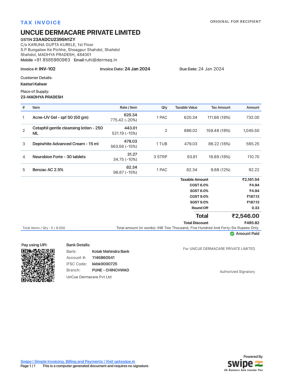

In [20]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np


path = pdf_path


images = convert_from_path(path)


img_1 = images[0]
img_1 = np.array(img_1)


plt.imshow(img_1)
plt.axis('off')
plt.show()


In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pdf2image import convert_from_path
import os

def overlay_ocr_text(img_path, save_name):
    ''' loads an image, recognizes text, and overlays the text on the image. '''


    if img_path.endswith('.pdf'):
        images = convert_from_path(img_path)
        img = np.array(images[0])
    else:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    dpi = 80
    fig_width, fig_height = int(img.shape[1] / dpi), int(img.shape[0] / dpi)
    plt.figure()
    f, axarr = plt.subplots(1, 2, figsize=(fig_width, fig_height))
    axarr[0].imshow(img)


    result = recognize_text(img_path)


    print("OCR Result Structure:", result)


    for item in result:

        if isinstance(item, tuple):
            if len(item) >= 3:
                bbox, text, prob = item[0], item[1], item[2]
                if prob >= 0.2:
                    print(f'Detected text: {text} (Probability: {prob:.2f})')


                    (top_left, top_right, bottom_right, bottom_left) = bbox
                    top_left = (int(top_left[0]), int(top_left[1]))
                    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))


                    cv2.rectangle(img=img, pt1=top_left, pt2=bottom_right, color=(255, 0, 0), thickness=10)


                    cv2.putText(img=img, text=text, org=(top_left[0], top_left[1] - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=8)
            else:
                print("Unexpected item format:", item)
        else:
            print("Item is not a tuple:", item)


    axarr[1].imshow(img)


    os.makedirs('./Output', exist_ok=True)

    plt.savefig(f'./Output/{save_name}_overlay.jpg', bbox_inches='tight')
    plt.close()


path = pdf_path
overlay_ocr_text(path, 'Text3_Output')


OCR Result Structure: [[([[66, 70], [144, 70], [144, 102], [66, 102]], 'TAX', 0.9996750818145799), ([[155, 69], [323, 69], [323, 105], [155, 105]], 'INVOICE', 0.9991099537222389), ([[1262, 65], [1585, 65], [1585, 92], [1262, 92]], 'ORIGINAL FOR RECIPIENT', 0.7447171042513199), ([[63, 125], [827, 125], [827, 169], [63, 169]], 'UNCUE DERMACARE PRIVATE LIMITED', 0.8839317805510816), ([[64, 178], [416, 178], [416, 208], [64, 208]], 'GSTIN 23AADCU2395NIZY', 0.986506135361355), ([[64, 212], [530, 212], [530, 244], [64, 244]], 'Clo KARUNA GUPTA KURELE, Ist Floor', 0.7120451492704234), ([[63, 241], [699, 241], [699, 277], [63, 277]], 'S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol', 0.7193621588251361), ([[63, 271], [519, 271], [519, 307], [63, 307]], 'Shahdol, MADHYA PRADESH, 484001', 0.6752428119898558), ([[66, 306], [384, 306], [384, 338], [66, 338]], 'Mobile +91 8585960963', 0.7138635517499824), ([[399, 303], [681, 303], [681, 341], [399, 341]], 'Email ruhi@dermaq.in', 0.897591551747069

<Figure size 640x480 with 0 Axes>

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import easyocr

reader = easyocr.Reader(['en'])

def recognize_text(img_path):
    ''' Recognizes text in the image. '''
    if img_path.endswith('.pdf'):

        images = convert_from_path(img_path)
        img_array = np.array(images[0])
        result = reader.readtext(img_array)
    else:
        img = cv2.imread(img_path)
        result = reader.readtext(img)

    return result

def overlay_ocr_text(img_path, save_name):
    ''' Loads an image, recognizes text, and overlays the text on the image. '''


    if img_path.endswith('.pdf'):
        images = convert_from_path(img_path)
        img = np.array(images[0])
    else:
        img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    dpi = 80
    fig_width, fig_height = img.shape[1] / dpi, img.shape[0] / dpi
    plt.figure(figsize=(fig_width, fig_height))


    result = recognize_text(img_path)


    overlay_img = img.copy()


    for (bbox, text, prob) in result:
        if prob >= 0.2:
            print(f'Detected text: "{text}" (Probability: {prob:.2f})')


            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = (int(top_left[0]), int(top_left[1]))
            bottom_right = (int(bottom_right[0]), int(bottom_right[1]))


            cv2.rectangle(overlay_img, pt1=top_left, pt2=bottom_right, color=(255, 0, 0), thickness=5)


            cv2.putText(overlay_img, text, org=(top_left[0], top_left[1] - 10),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255, 0, 0), thickness=2)

    #
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_img)
    plt.title('Overlay Image with OCR')
    plt.axis('off')


    output_path = f'./Output/{save_name}_overlay.jpg'
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

    print(f'Overlay image saved at: {output_path}')


path = pdf_path
overlay_ocr_text(path, 'Text3_Output')


Detected text: "TAX" (Probability: 1.00)
Detected text: "INVOICE" (Probability: 1.00)
Detected text: "ORIGINAL FOR RECIPIENT" (Probability: 0.74)
Detected text: "UNCUE DERMACARE PRIVATE LIMITED" (Probability: 0.88)
Detected text: "GSTIN 23AADCU2395NIZY" (Probability: 0.99)
Detected text: "Clo KARUNA GUPTA KURELE, Ist Floor" (Probability: 0.71)
Detected text: "S.P Bungalow Ke Pichhe, Shoagpur Shahdol, Shahdol" (Probability: 0.72)
Detected text: "Shahdol, MADHYA PRADESH, 484001" (Probability: 0.68)
Detected text: "Mobile +91 8585960963" (Probability: 0.71)
Detected text: "Email ruhi@dermaq.in" (Probability: 0.90)
Detected text: "Invoice #: INV-102" (Probability: 0.68)
Detected text: "Invoice Date: 24 Jan 2024" (Probability: 1.00)
Detected text: "Due Date: 24 Jan 2024" (Probability: 0.80)
Detected text: "Customer Details:" (Probability: 1.00)
Detected text: "Kasturi Kalwar" (Probability: 0.86)
Detected text: "Place of Supply:" (Probability: 0.98)
Detected text: "23-MADHYA PRADESH" (Probab